# Mask R-CNN - Inspect Cal Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [31]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mrcnn.config import Config

import skimage
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


%matplotlib inline 
%load_ext autoreload
%autoreload 2
# Root directory of the project
ROOT_DIR = '/home/sky8/cal/data/ddsm-mass/'
# ROOT_DIR2 = '/data1/share/shiky/Mask_RCNN'
img_train = os.path.join(ROOT_DIR, 'train', 'images') 
img_val = os.path.join(ROOT_DIR, 'validation', 'images') 

mask_train = os.path.join(ROOT_DIR, 'train', 'masks') 
mask_val = os.path.join(ROOT_DIR, 'validation', 'masks') 


train_imglist = os.listdir(img_train)
val_imglist = os.listdir(img_val)

train_count = len(train_imglist)
val_count = len(val_imglist)
# width = 1280
# height = 800
# Directory to save logs and trained model
MODEL_DIR = os.path.join("/home/sky8/project/sky8/cal/", "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR2, "mask_rcnn_coco.h5")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class CalConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "mass"

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = train_count// IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, val_count // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.1

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400
    
config = CalConfig()
config.display()   
 



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           mass
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_R

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [4]:
class CalDataset(utils.Dataset):
    """Create customized dataset class to load data"""
    def load_cal(self,count, data_dir, mask_dir, namelist):
        """load """
        
        #Add classes
        self.add_class("breast", 1, "calcification" )
        self.add_class("breast", 2, "mass")
        
        #Add images
        
        for i in range(count):
            src = namelist[i]
            name = src.split('_')
            full_name = '_'.join(name[0:4])
            mask_path= os.path.join(mask_dir,full_name.split('.')[0])

            self.add_image("breast", image_id = i, path = os.path.join(data_dir, full_name), mask_path = mask_path , full_name =full_name)

            



    def load_mask(self, image_id):
        """load the mask image"""
        info = self.image_info[image_id]
        mask_path = info['mask_path']
        mask = []
        for i in range(10):
            full_mask_path = mask_path + '_' +str(i) +'.jpg'
        
            if os.path.exists(full_mask_path):
       
                m = skimage.io.imread(full_mask_path).astype(bool)
                mask.append(m)
            else:
                continue
        mask = np.stack(mask, axis=-1)
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("mass")],dtype=np.int32)
        
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)* 2
        
    def load_name(self, image_id):
        """load the image name"""
        info = self.image_info[image_id]
        
        return info['full_name']
        

In [5]:
class InferenceConfig(CalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "square"
    RPN_NMS_THRESHOLD = 0
    DETECTION_MIN_CONFIDENCE = 0.8
    BACKBONE = "resnet101"
    
config = InferenceConfig()

In [6]:
dataset = CalDataset()
dataset.load_cal(val_count, img_val, mask_val, val_imglist)
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 231
Classes: ['BG', 'calcification', 'mass']


In [7]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

mode = "last"

if mode == "coco":
    model_path = "/home/sky8/cal/logs/calcification-coco20180419T0119/mask_rcnn_calcification-coco_0040.h5"
    
if mode == "imagenet-resnet50":
    model_path = "/home/sky8/cal/logs/calcification-resnet5020180419T0309/mask_rcnn_calcification-resnet50_0040.h5"
    
if mode == "imagenet-resnet101":
    model_path = "/home/sky8/cal/code/resnet101_weights_tf.h5"
# 
elif mode == "last":
    model_path = model.find_last()[1]


# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)



Loading weights from  /home/sky8/project/sky8/cal/logs/mass20180502T0132/mask_rcnn_mass_0240.h5


In [55]:

class InferenceConfig(CalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "square"
    RPN_NMS_THRESHOLD = 0
    DETECTION_MIN_CONFIDENCE = i
    BACKBONE = "resnet101"

config = InferenceConfig()
model.config = config
model.config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.8999999999999999
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           mass
NUM_CLASSES                    3
POOL_SIZE                 

In [50]:
all_map = []
for i in np.arange(0.5,1.0,0.1):

    class InferenceConfig(CalConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
        IMAGE_RESIZE_MODE = "square"
        RPN_NMS_THRESHOLD = 0
        DETECTION_MIN_CONFIDENCE = i
        BACKBONE = "resnet101"

    config = InferenceConfig()
    model.config = config
    from mrcnn import utils
#     image_ids = np.random.choice(dataset.image_ids, 100)
    APs = []
    count = 0
    for image_id in dataset.image_ids:
        # image_id = random.choice(dataset.image_ids)
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]
    #     print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                                dataset.image_reference(image_id)))
    #     print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

        # Run object detection
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=0)

        # Display results
        r = results[0]
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)


        # Compute AP over range 0.5 to 0.95 and print it
        try:
            AP = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                               r['rois'], r['class_ids'], r['scores'], r['masks'],
                               verbose=0)
        except:
            imgplot = plt.imshow(image)
            plt.show()
            visualize.display_differences(
            image,
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            dataset.class_names, ax=get_ax(),
            show_box=False, show_mask=False,
            iou_threshold=0.5, score_threshold=0.5)

        print(AP)
        APs.append(AP)


    print(i)
    print("mAP: ", np.mean(APs))
    all_map.append(np.mean(APs))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6601.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  255.00000  max:  313.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5386.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4696.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  196.00000  max:  324.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4728.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  252.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4696.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  291.00000  max:  372.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4768.00000  float64
anchors    

0.14285714285714285
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5768.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  234.00000  max:  405.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4824.00000 

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  135.00000  max:  358.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4792.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  244.00000  max:  422.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  244.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5504.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  213.00000  max:  300.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4704.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4808.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  183.00000  max:  220.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6841.00000  float64
anchors    

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  201.00000  max:  340.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4951.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5872.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  269.00000  max:  390.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors

0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (2,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:  157.00000  max:  357.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool
0.6666666666666666
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5311.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  146.00000  max:  287.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6346.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  179.00000  max:  330.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4704.00000  float64
anchors

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4608.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  126.00000  max:  389.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  236.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  236.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4216.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6451.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  205.00000  max:  382.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5881.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  153.00000  max:  190.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6376.00000  float64
anchors    

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4416.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  312.00000  max:  410.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4752.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  143.00000  max:  405.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5880.00000  float64
anchors    

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4584.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  147.00000  max:  362.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4996.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4776.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  216.00000  max:  382.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5506.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5311.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  201.00000  max:  415.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  254.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6316.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4800.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  127.00000  max:  380.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6391.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5832.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  209.00000  max:  267.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5146.00000  float64
anchors

0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5760.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  210.00000  max:  246.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4656.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5664.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  205.00000  max:  274.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  239.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4951.00000  float64
anchors

0.14285714285714285
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  215.00000  max:  280.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.16666666666666666
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5266.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  153.00000  max:  303.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.25
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5728.00000  float64
anchor

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   88.00000  max:  430.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5446.00000  float64
anchors    

0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  244.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4306.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  184.00000  max:  352.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5688.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  118.00000  max:  387.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5944.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  292.00000  max:  383.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4376.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  319.00000  max:  392.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5864.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  125.00000  max:  281.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5968.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  170.00000  max:  216.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4531.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  128.00000  max:  214.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5161.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5904.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  271.00000  max:  343.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5744.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5904.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  123.00000  max:  216.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5206.00000  float64
anchors    

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  205.00000  max:  247.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5236.00000  float64
anchors

0.25
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6061.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  196.00000  max:  433.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4616.00000  float64
anchor

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6076.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  264.00000  max:  362.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5232.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5806.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  238.00000  max:  309.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6256.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5131.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  245.00000  max:  403.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5386.00000  float64
anchors    

0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4632.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  262.00000  max:  353.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6871.00000  float64
anchors

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  254.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4552.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  260.00000  max:  389.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  250.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5664.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  188.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  188.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5251.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  191.00000  max:  323.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4696.00000  float64
anchors    

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6871.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  285.00000  max:  372.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6048.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5800.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  125.00000  max:  256.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4744.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4688.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  169.00000  max:  405.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.25
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5896.00000  float64
anchor

0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  254.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4480.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  124.00000  max:  220.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  143.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  143.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5616.00000  

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5026.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  241.00000  max:  325.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  239.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5896.00000  float64
anchors

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5912.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  142.00000  max:  388.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6001.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4544.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  211.00000  max:  286.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.25
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5944.00000  float64
anchor

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  329.00000  max:  419.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5476.00000  float64
anchors

0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  235.00000  max:  319.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  254.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4544.00000  

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5752.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   91.00000  max:  346.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4336.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4784.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  211.00000  max:  425.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5888.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  137.00000  max:  349.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  230.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  230.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5688.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5236.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  295.00000  max:  346.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6406.00000  floa

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4800.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  109.00000  max:  165.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  223.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  223.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5206.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  287.00000  max:  415.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4640.00000  floa

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5688.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  243.00000  max:  313.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  248.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4376.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4800.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  105.00000  max:  431.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4744.00000  float64
anchors    

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6691.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  255.00000  max:  346.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6121.00000  float64
anchors    

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4616.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  303.00000  max:  337.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  238.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5824.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  328.00000  max:  389.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4728.00000  float64
anchors    

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  191.00000  max:  315.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5506.00000  float64
anchors

0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6526.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  130.00000  max:  329.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5236.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5608.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  240.00000  max:  355.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4648.00000  float64
anchors    

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  240.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4876.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  326.00000  max:  385.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4672.00000  float64
anchors

0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5648.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  203.00000  max:  372.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4568.00000  

0.16666666666666666
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5386.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  333.00000  max:  376.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  202.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5416.00000 

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  198.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  198.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5536.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   84.00000  max:  209.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5904.00000  float64
anchors    

0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  240.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5752.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  294.00000  max:  359.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  ma

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  253.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4552.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  114.00000  max:  353.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4760.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6736.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  219.00000  max:  289.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4608.00000  float64
anchors    

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5281.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  185.00000  max:  284.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5356.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  198.00000  max:  271.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5920.00000  float64
anchors    

1.0
0.7999999999999999
mAP:  0.2657802514945372
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6601.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  255.00000  max:  313.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min: 

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4696.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  196.00000  max:  324.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4728.00000  float64
anchors    

0.3333333333333333
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  252.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4696.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  291.00000  max:  372.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4768.00000  

0.14285714285714285
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5768.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  234.00000  max:  405.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4824.00000 

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  135.00000  max:  358.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4792.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  244.00000  max:  422.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  244.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5504.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  213.00000  max:  300.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4704.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4808.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  183.00000  max:  220.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6841.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  201.00000  max:  340.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4951.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5872.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  269.00000  max:  390.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors

0.5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (2,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:  157.00000  max:  357.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool
0.6666666666666666
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5311.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  146.00000  max:  287.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6346.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5491.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  179.00000  max:  330.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4704.00000  float64
anchors

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4608.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  126.00000  max:  389.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  236.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  236.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4216.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6451.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  205.00000  max:  382.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5881.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  153.00000  max:  190.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 6376.00000  float64
anchors    

1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4416.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  312.00000  max:  410.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4736.00000  float64
anchors

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4752.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  143.00000  max:  405.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5880.00000  float64
anchors    

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4584.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  147.00000  max:  362.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
1.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4996.00000  float64
anchors

0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 4776.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  216.00000  max:  382.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
0.0
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 5506.00000  float64
anchors

In [51]:
all_map

[0.2657802514945372,
 0.2657802514945372,
 0.2657802514945372,
 0.2657802514945372,
 0.2657802514945372]

### Compute AP on Batch of Images

In [46]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 12
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

 12 [4696 2528    3]   AP: 0.00
 13 [4728 2584    3]   AP: 0.00


ValueError: cannot reshape array of size 0 into shape (0)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [42]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (65472, 4)            min: -181.00000  max:  629.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:   -1.23430  max:    0.46875  float64
positive_anchors         shape: (1, 4)                min:  112.00000  max:  360.00000  int32
negative_anchors         shape: (63, 4)               min:  -64.00000  max:  511.00000  int32
neutral anchors          shape: (65408, 4)            min: -181.00000  max:  629.00000  int32
refined_anchors          shape: (1, 4)                min:  114.00000  max:  353.00000  float32


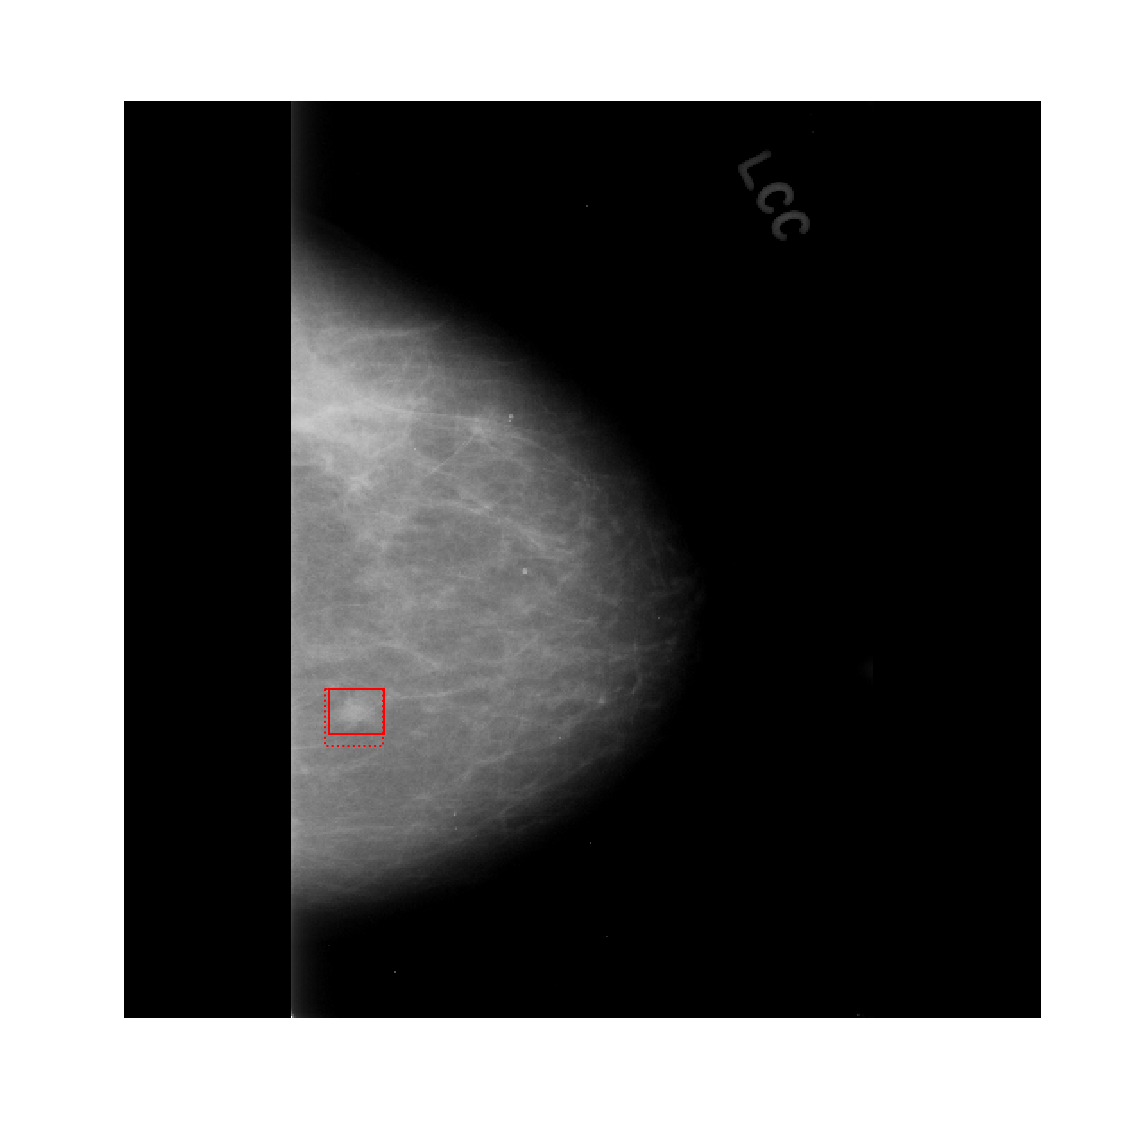

In [43]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [44]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.25049  max:    1.12524  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.28353  max:    1.13552  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (252,)                min:    0.00000  max: 5998.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


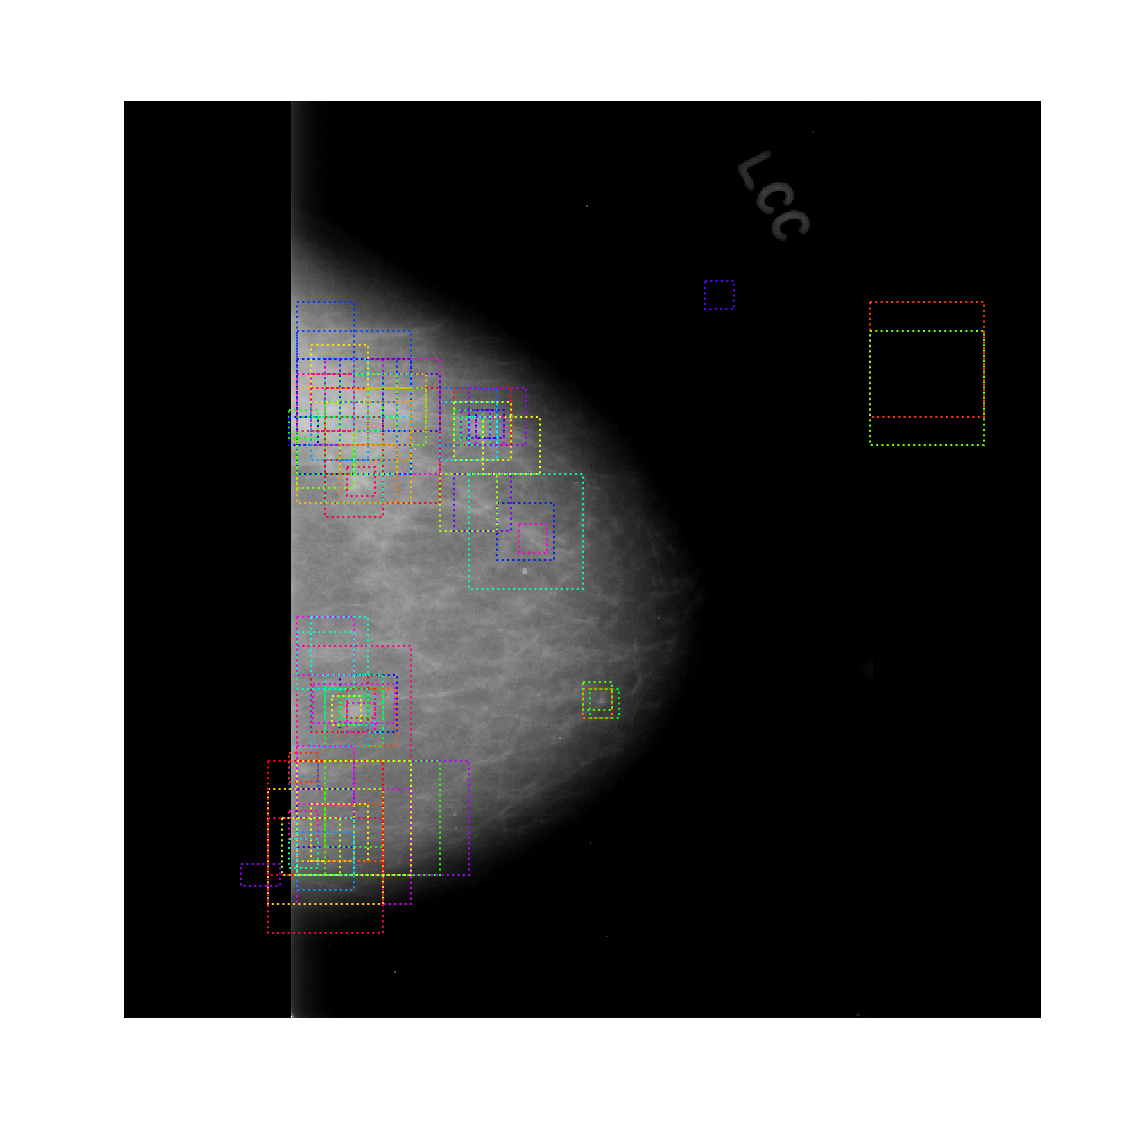

In [47]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

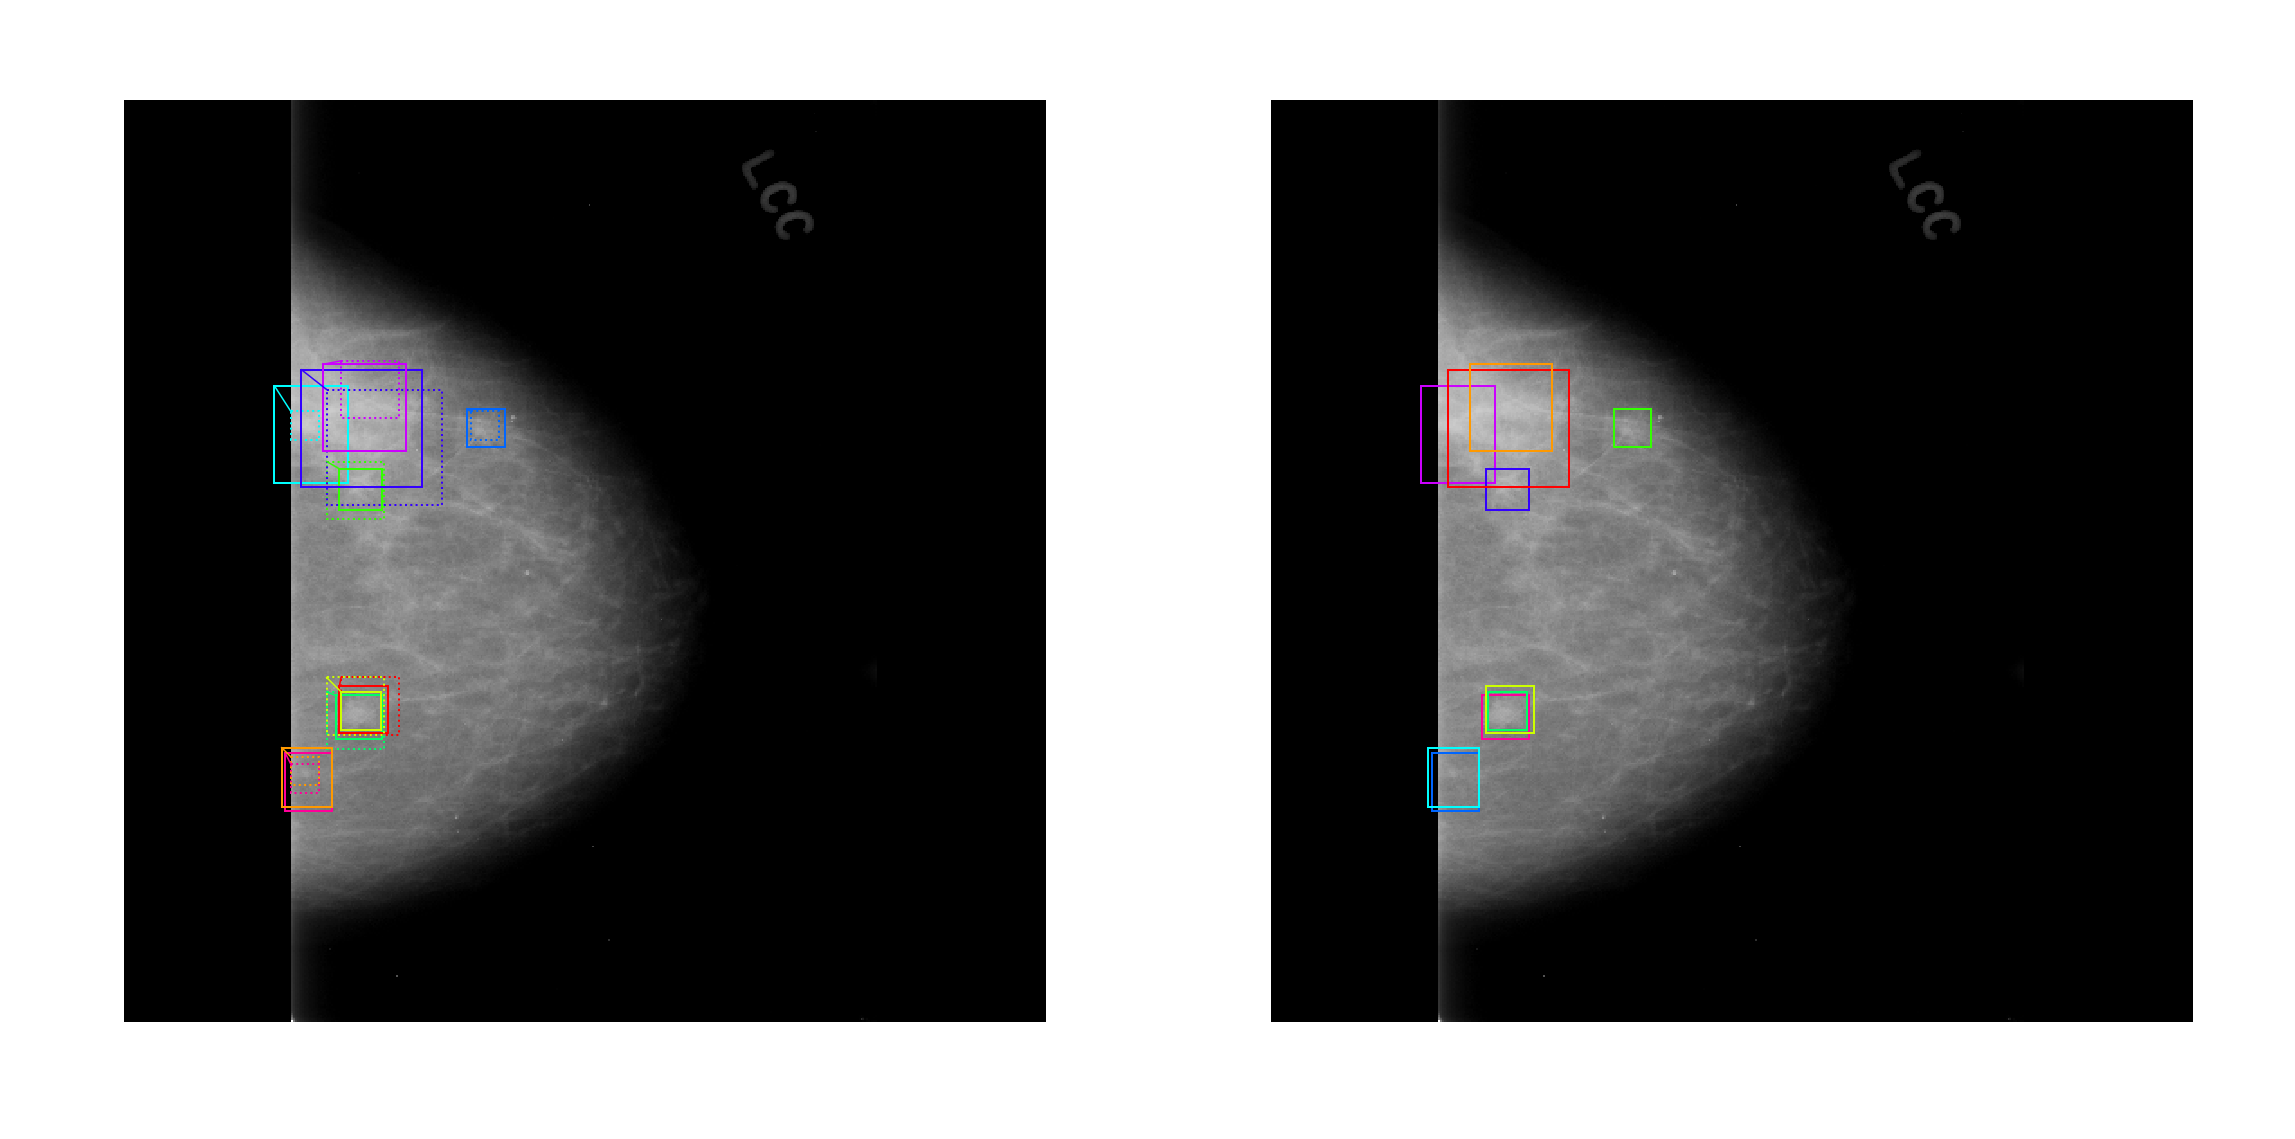

In [48]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 10
ax = get_ax(1, 2)
visualize.draw_boxes(
    image, ax=ax[0],
    boxes=utils.denorm_boxes(rpn["pre_nms_anchors"][0, :limit], image.shape[:2]), 
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors"][0, :limit], image.shape[:2]))
visualize.draw_boxes(
    image, ax=ax[1],
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, :limit], image.shape[:2]))

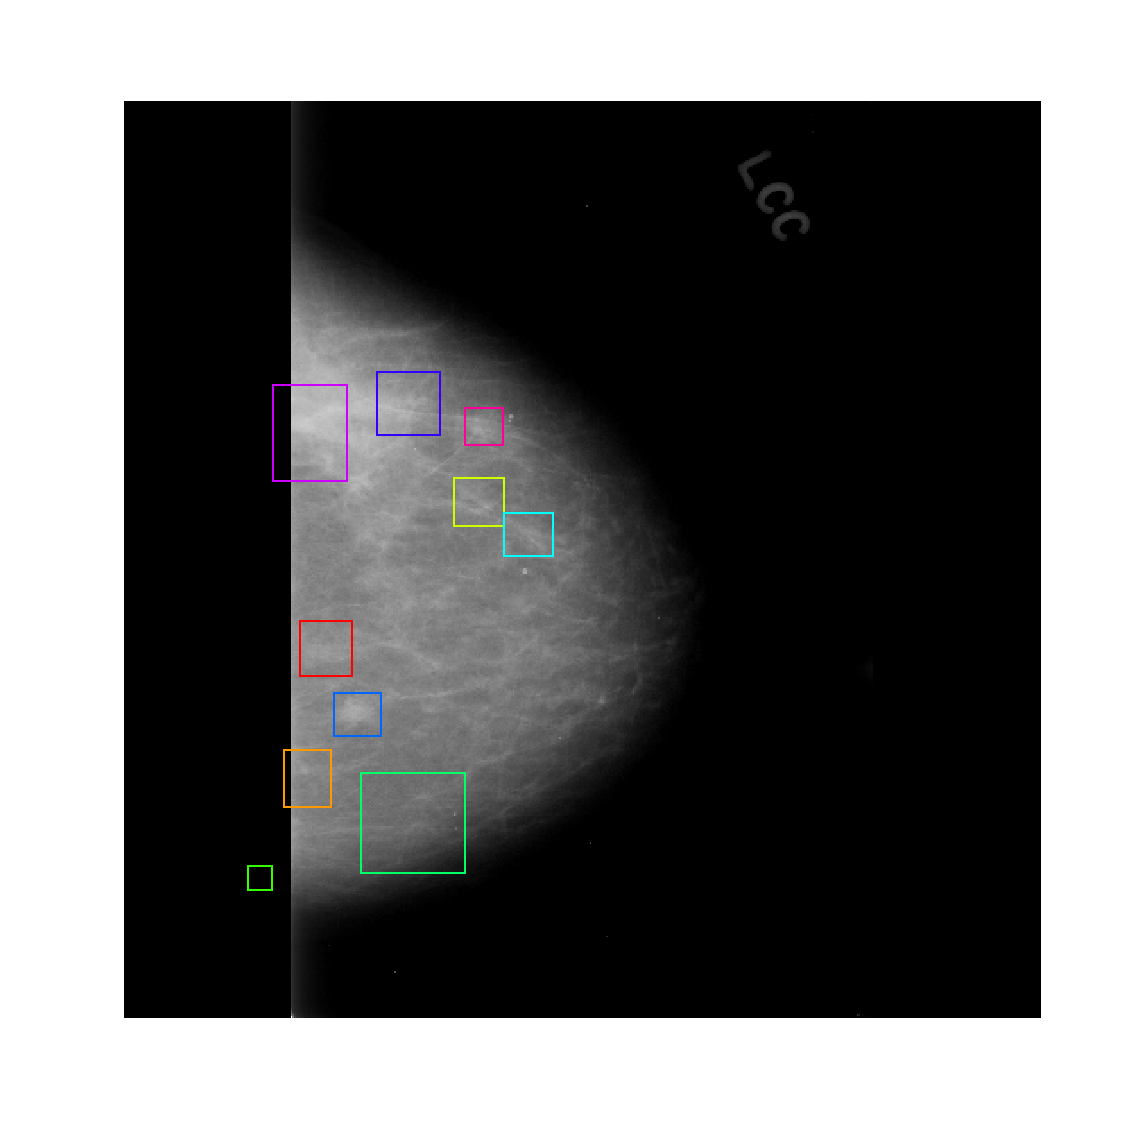

In [49]:
# Show refined anchors after non-max suppression
limit = 10
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn["refined_anchors_clipped"][0, ixs], image.shape[:2]))

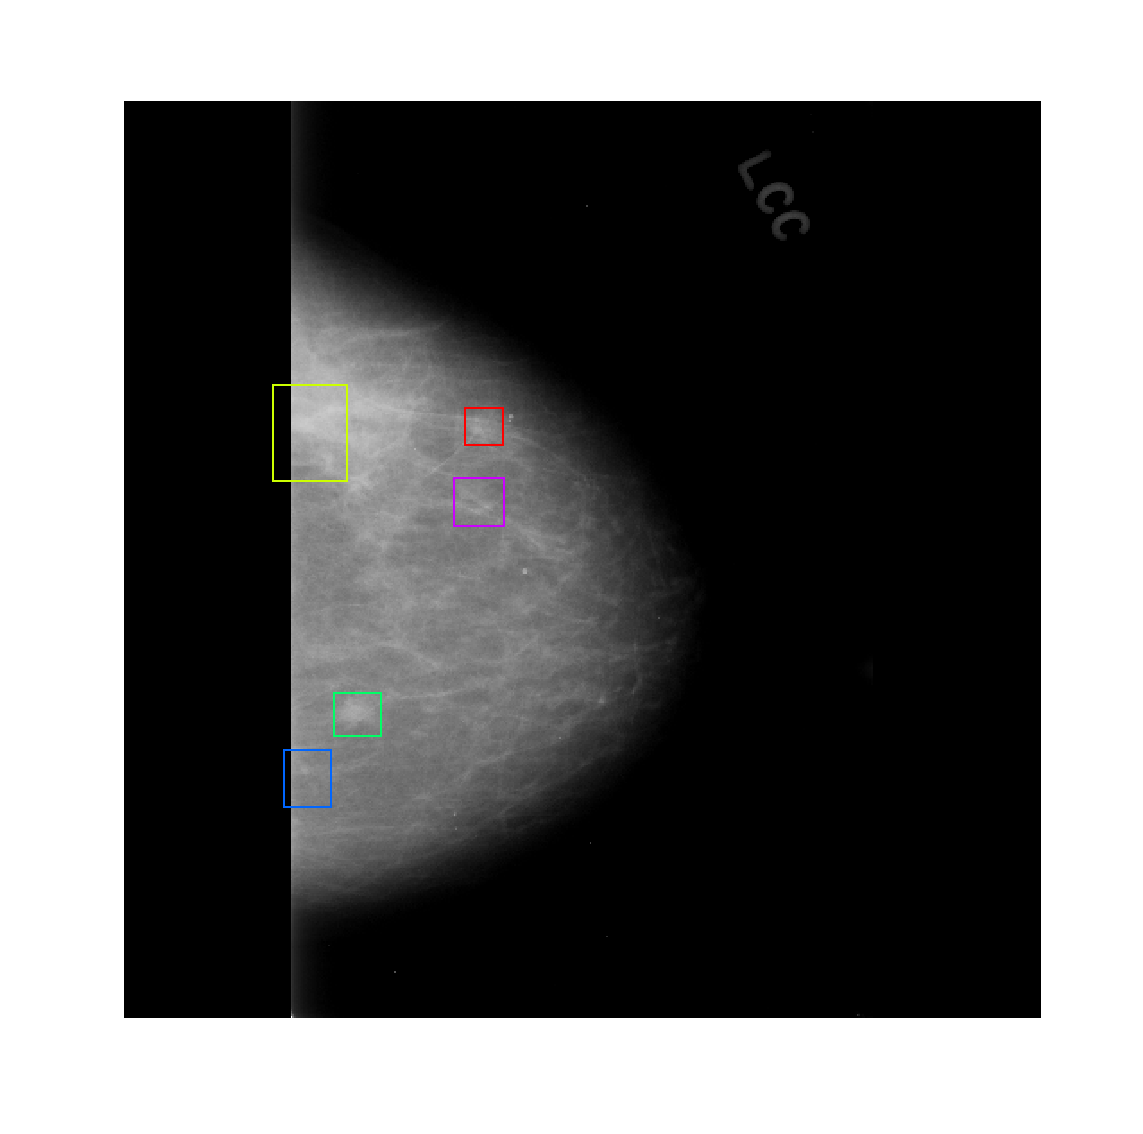

In [50]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 5
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [51]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 2000, 3, 4)       min:   -3.08735  max:    6.54397  float32
masks                    shape: (1, 400, 28, 28, 3)   min:    0.00903  max:    0.99964  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    2.00000  float32


2 detections: ['mass' 'mass']


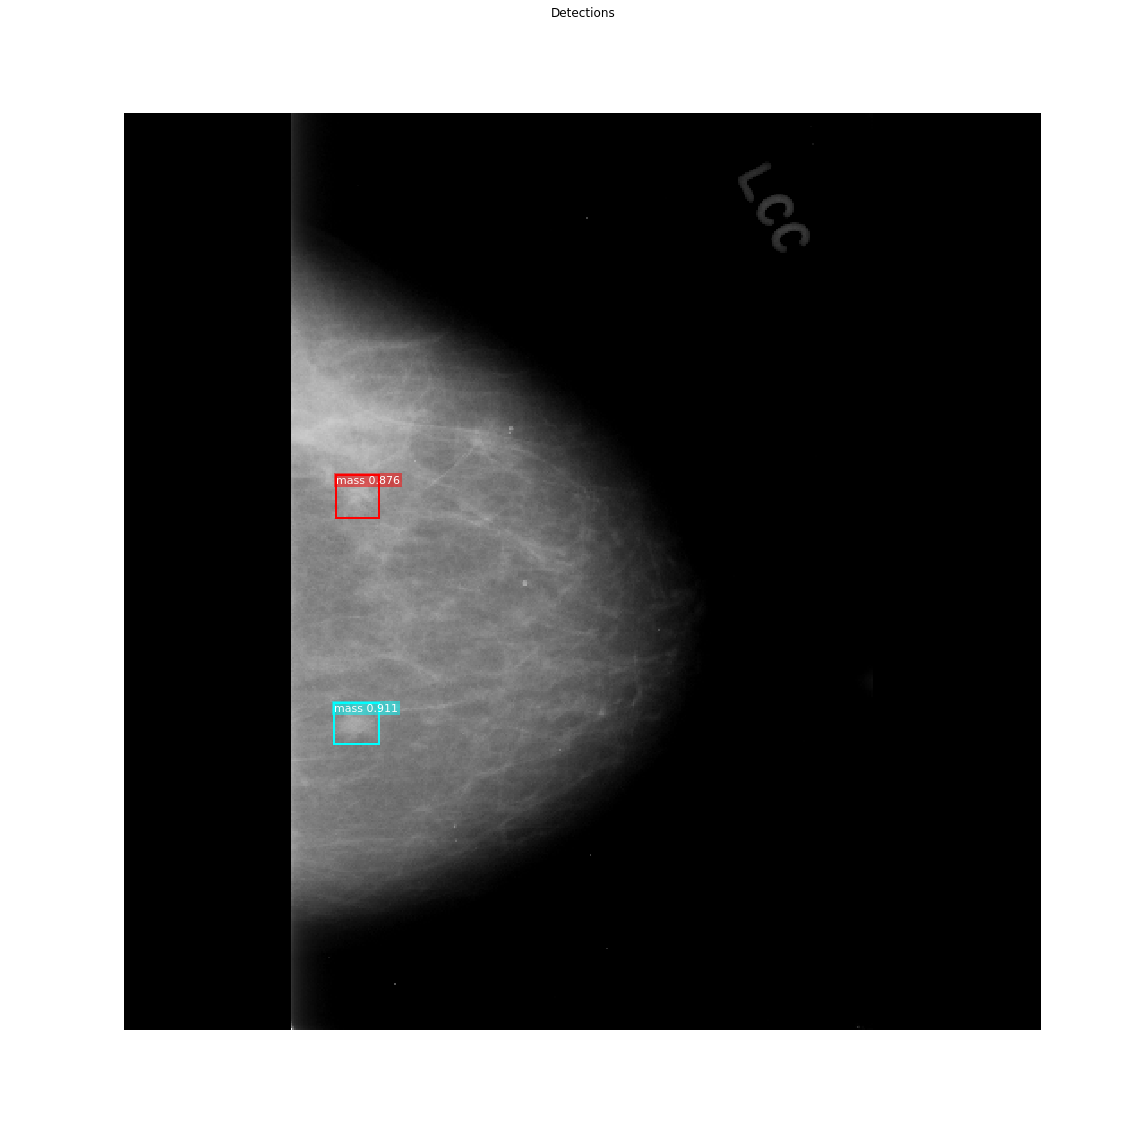

In [52]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [53]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

150 Valid proposals out of 2000
16 Positive ROIs
[('BG', 1984), ('mass', 16)]


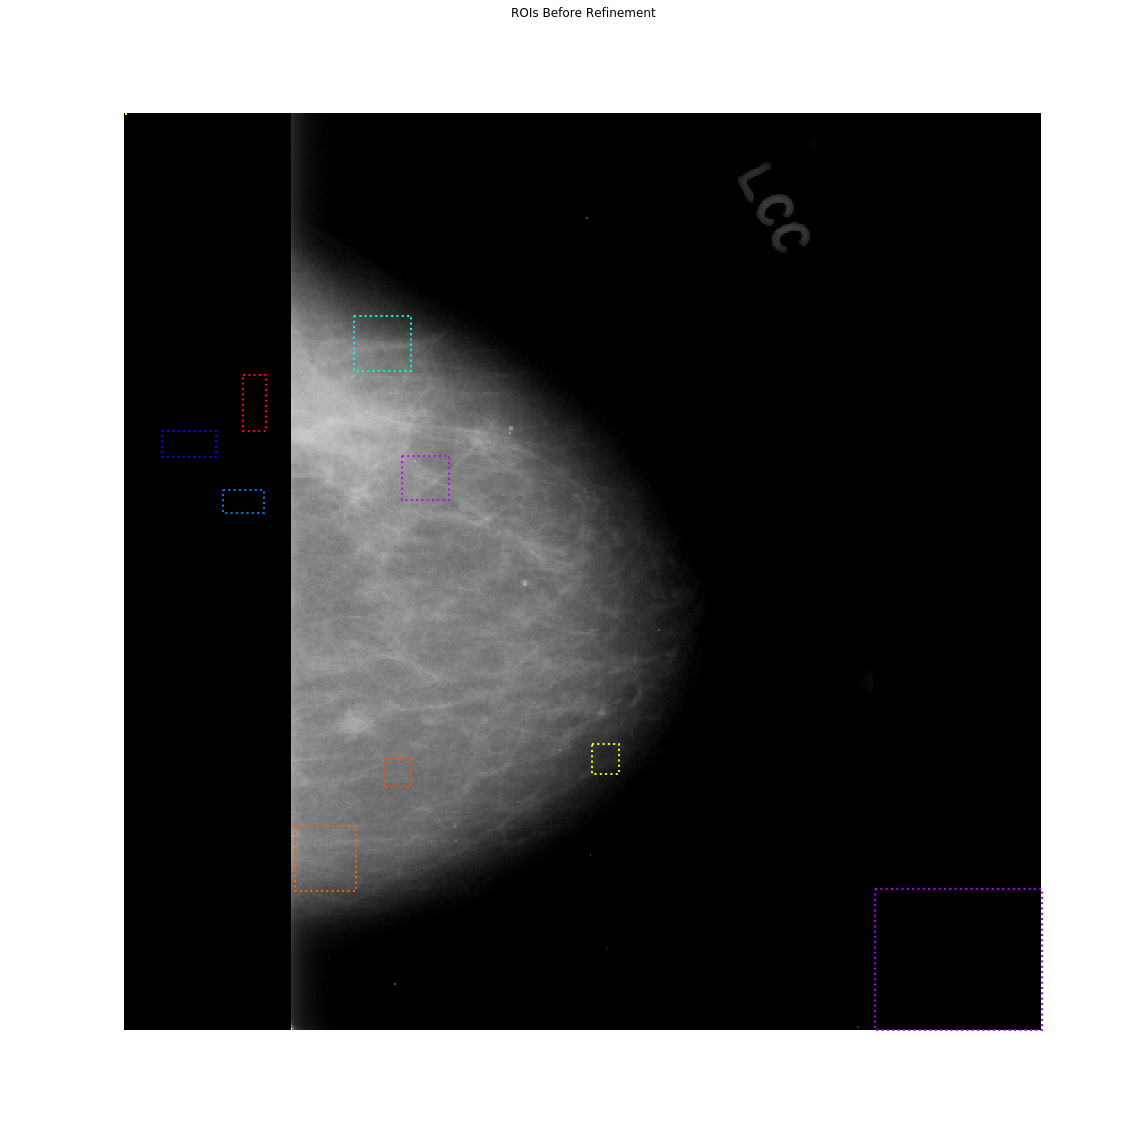

In [54]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -3.08735  max:    4.54146  float32
refined_proposals        shape: (2000, 4)             min:   -0.01551  max:    1.01851  float32


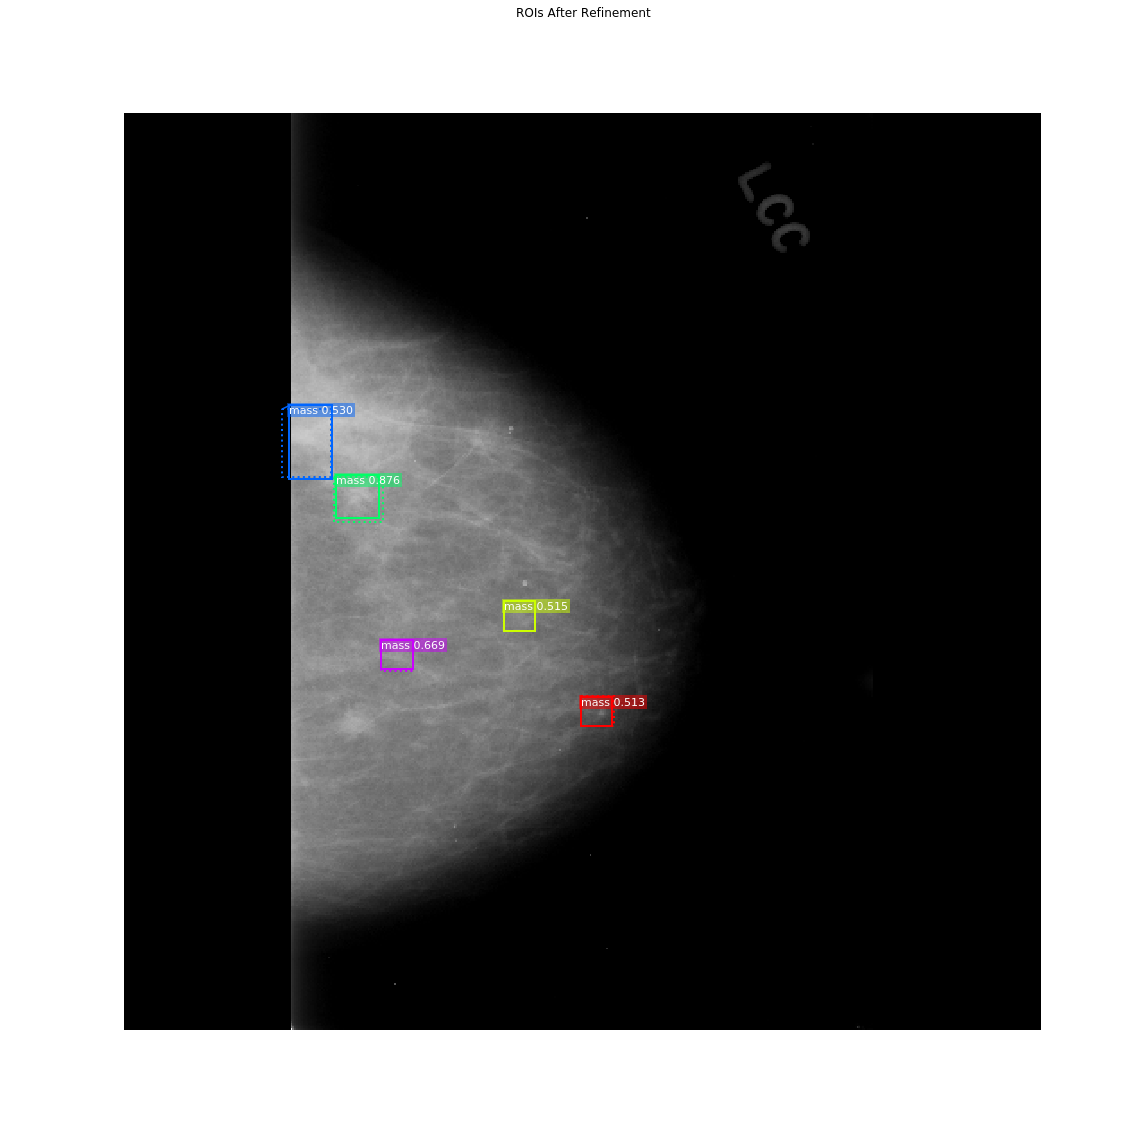

In [55]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")